In [3]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.colors

In [4]:
# Read the csv archives

df1 = pd.read_csv('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-espacio-publico-e-higiene-urbana/arbolado-espacios-verdes/arbolado-en-espacios-verdes.csv')
df2 = pd.read_csv('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/atencion-ciudadana/arbolado-publico-lineal/arbolado-publico-lineal-2017-2018.csv')


# Edit the dataframes in order to keep only the information I am interested in

df1_jacarandas = df1[df1['nombre_com'] == 'Jacarandá']
df2_jacarandas = df2[df2['nombre_cientifico'] == 'Jacaranda mimosifolia']

df1_jacarandas = df1_jacarandas[['long', 'lat']]
df2_jacarandas = df2_jacarandas[['long', 'lat']]

df1_jacarandas = df1_jacarandas.reset_index(drop=True)
df2_jacarandas = df2_jacarandas.reset_index(drop=True)


# Concatenate the two different datasets

df = pd.concat([df1_jacarandas, df2_jacarandas])

<ipython-input-4-e2b96d362d8b>:4: DtypeWarning: Columns (2,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/atencion-ciudadana/arbolado-publico-lineal/arbolado-publico-lineal-2017-2018.csv')


<ipython-input-5-0c7808af906d>:63: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cuadro_expandido['geometry'] = cuadro_expandido.buffer(grado_adicional)


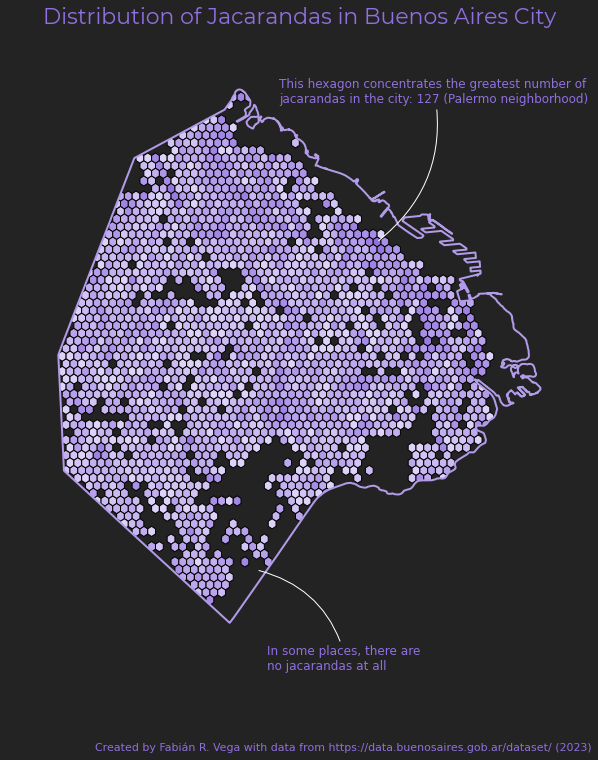

In [5]:
# Define the colors for hexagons, text, and background

color_fondo = '#232323'
color_jacaranda = '#906FDE'
color_jacaranda_suave = '#DDD2F7'
color_jacaranda_intermedio = '#B29BE8'


# Create a GeoDataFrame based on the previous Jacaranda dataframe

geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')


# Load the boundaries of Buenos Aires City

ciudad_ba = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/perimetro/perimetro.zip')


# Obtain the maximum and minimum coordinates of the city's boundaries

lat_min, lat_max = ciudad_ba.bounds['miny'].min(), ciudad_ba.bounds['maxy'].max()
lon_min, lon_max = ciudad_ba.bounds['minx'].min(), ciudad_ba.bounds['maxx'].max()


# Define the size of the hexagons inside the city

gridsize = 62


# Create the figure

fig, ax = plt.subplots(figsize=(12, 12))


# Define the color scale for the hexagons

color_map = matplotlib.colors.LinearSegmentedColormap.from_list("", [color_jacaranda_suave, color_jacaranda])


# Create the hexagon map of the Jacarandas distribution using hexbin

hb = ax.hexbin(gdf['long'], gdf['lat'], 
    gridsize=gridsize,
    bins='log',
    extent=[lon_min, lon_max, lat_min, lat_max],
    cmap=color_map,
    edgecolor='black',
    mincnt=1)


# Use a trick to hide "extra" hexagons that extend beyond the boundaries of the city

grado_adicional = 0.01
xmin, ymin, xmax, ymax = ciudad_ba.total_bounds
xmin -= grado_adicional
ymin -= grado_adicional
xmax += grado_adicional
ymax += grado_adicional

cuadro_expandido = gpd.GeoDataFrame(geometry=[ciudad_ba.envelope.unary_union], crs=ciudad_ba.crs)

cuadro_expandido['geometry'] = cuadro_expandido.buffer(grado_adicional)

fuera_ciudad = gpd.overlay(cuadro_expandido, ciudad_ba, how='difference')

fuera_ciudad.plot(ax=ax, color=color_fondo)


# Add the boundaries of the city

ciudad_ba.plot(ax=ax, color='none', edgecolor=color_jacaranda_intermedio, linewidth=2)


# Set the facecolor

fig.set_facecolor(color_fondo)


# Identify the hexagon with the highest concentration of Jacarandas

counts = hb.get_array()
max_count_index = counts.argmax()
max_count = counts[max_count_index]

lon_centers, lat_centers = hb.get_offsets().T
max_count_lon = lon_centers[max_count_index]
max_count_lat = lat_centers[max_count_index]


# Add the title

titulo_config = {
    'fontsize': 22,
    'color': color_jacaranda,
    'fontfamily': 'Montserrat'}

ax.set_title('Distribution of Jacarandas in Buenos Aires City',
             fontdict=titulo_config)


# Add two annotations

x = 257.0
y = 190.0

ax.annotate('In some places, there are \nno jacarandas at all',
            xy=(x, y),
            xytext=(x + 10, y - 100),
            fontsize=12,
            color=color_jacaranda,
            xycoords='figure points',
            arrowprops=dict(color='white', arrowstyle='-', connectionstyle='arc3,rad=0.3'))

ax.annotate(f'This hexagon concentrates the greatest number of \njacarandas in the city: {int(max_count)} (Palermo neighborhood)',
            xy=(max_count_lon, max_count_lat),
            xytext=(max_count_lon - 0.04, max_count_lat + 0.055),
            fontsize=12,
            color=color_jacaranda,
            arrowprops=dict(color='white', arrowstyle='-', connectionstyle='arc3,rad=-0.3'),
            ha='left',
            va='top')


# Add the sign

texto_creacion = "Created by Fabián R. Vega with data from https://data.buenosaires.gob.ar/dataset/ (2023)"
ax.text(0.15, -0.1, texto_creacion, ha='left', va='center', color=color_jacaranda, fontsize=11, transform=ax.transAxes)


# Hide ticks, x and y labels, and axis

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.axis('off')


# Save the figure

#ruta_guardado = ...
#plt.savefig(ruta_guardado, dpi=300, bbox_inches='tight')


# Show the map

plt.show()